# AirBnB Dataset

table schemata [here](https://docs.google.com/document/d/1ezVFDe506zK1CuuNhNmzHEj_iNnL67hDrFzSap9V7S0/edit?usp=sharing) for the data

In [1]:
import urllib.request
import zipfile
import os

print("Starting download ...")
url = "https://github.com/aihack20/airbnb_challenge/releases/download/data/data-airbnb.zip"
with urllib.request.urlopen(url) as src:
    with open("tmp_airbnb_data.zip", "wb") as dest:
        dest.write(src.read())
print("Unpacking archive ...")
os.makedirs("airbnb_data", exist_ok=True)
with zipfile.ZipFile("tmp_airbnb_data.zip", compression=zipfile.ZIP_DEFLATED) as zip_f:
    zip_f.extractall("airbnb_data")
print("Done!")

Starting download ...
Unpacking archive ...
Done!


In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from matplotlib import pyplot as plt
import numpy as np
import re
import random
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *

In [76]:
# Load the data (will take a short while)
calendar = pd.read_csv("airbnb_data/calendar.csv")
demographics = pd.read_csv("airbnb_data/demographics.csv")
econ_state = pd.read_csv("airbnb_data/econ_state.csv")
listings = pd.read_csv("airbnb_data/listings.csv")
real_estate = pd.read_csv("airbnb_data/real_estate.csv")
venues = pd.read_csv("airbnb_data/venues.csv")

## Data Cleaning

### Features with missing data deleted

In [77]:
percent_missing = listings.isnull().sum() * 100 / len(listings)
missing_listings_df = pd.DataFrame({'column_name': listings.columns,
                                 'percent_missing': percent_missing})

Text(0, 0.5, 'Percentage missing values')

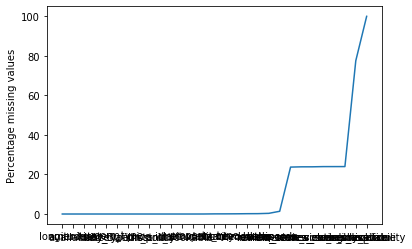

In [78]:
missing_listings_df.sort_values('percent_missing', inplace=True)
plt.plot(missing_listings_df['percent_missing'])
plt.ylabel('Percentage missing values')
# seems natural to drop those at the cutoff for around 20% missing data

In [79]:
cols_to_drop = ['has_availability', 'weekly_price', 'review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating', 'host_id', 'id', 'name', 'longitude', 'latitude']
listings_drop = listings.drop(columns=cols_to_drop)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


### drop datapoints with nan

In [80]:
cols_to_delete_na = ['property_type', 'city', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'zipcode']
listings_drop = listings_drop.dropna(axis=0, subset=cols_to_delete_na)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


In [81]:
# also drop zipcode and amenities for now
listings_drop = listings_drop.drop(columns=['zipcode', 'amenities'])

### Now standardise and one-hot encode etc. data

In [82]:
cols_to_scale = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
listings_drop[cols_to_scale] = scaler.fit_transform(listings_drop[cols_to_scale])

In [83]:
listings_drop.head(4)

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state
0,-0.518121,1.599729,-0.379388,Real Bed,-0.286649,-0.555898,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY
1,0.480388,2.197547,-0.379388,Real Bed,-0.286649,-0.555898,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY
2,0.480388,2.197547,3.746315,Real Bed,2.286144,1.213739,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY
3,-0.018867,0.005549,-0.379388,Real Bed,-0.286649,-0.555898,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY


In [84]:
df = listings_drop

## helper functions

In [85]:
def train_cats(df, cat_vars):
    # numercalize/categoricalize
    for name, col in df.items(): 
        if name in cat_vars:
            df[name] = col.cat.codes + 1
    df = pd.get_dummies(df, dummy_na=True)
    return df

In [86]:
cat_vars = ['bed_type', 'cancellation_policy', 'city', 'instant_bookable', 'metropolitan', 'property_type', 'room_type', 'state']
cont_vars = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds']

In [87]:
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered()
df = train_cats(df, cat_vars)

In [88]:
# delete rows of price 0, which are -inf when taken log of price
df = df[df.price != 0]

In [89]:
df

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state
0,-0.518121,1.599729,-0.379388,5,-0.286649,-0.555898,3,119,1,1,99.0,18,2,8
1,0.480388,2.197547,-0.379388,5,-0.286649,-0.555898,1,119,2,1,200.0,1,2,8
2,0.480388,2.197547,3.746315,5,2.286144,1.213739,5,119,1,1,300.0,18,1,8
3,-0.018867,0.005549,-0.379388,5,-0.286649,-0.555898,5,75,1,1,125.0,1,1,8
4,0.480388,0.902276,-0.379388,5,-0.286649,-0.555898,3,119,2,1,69.0,18,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59818,-0.518121,1.998274,-0.379388,5,-0.286649,-0.555898,1,124,2,4,37.0,18,2,2
59819,-0.518121,-0.791541,-0.379388,5,-0.286649,-0.555898,1,107,2,4,42.0,1,2,5
59820,0.979642,1.201184,-0.379388,5,-0.286649,0.328921,1,11,1,4,155.0,1,1,5
59821,1.478897,0.503731,-0.379388,5,-0.286649,1.213739,5,121,2,4,75.0,18,2,5


In [107]:
df.columns

Index(['accommodates', 'availability_30', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'city', 'instant_bookable',
       'metropolitan', 'price', 'property_type', 'room_type', 'state'],
      dtype='object')

In [108]:
len(df.columns)

14

In [90]:
# calculate embedding sizes, so we can treat categorical features
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered()
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [91]:
cat_sz

[('bed_type', 6),
 ('cancellation_policy', 8),
 ('city', 133),
 ('instant_bookable', 3),
 ('metropolitan', 6),
 ('property_type', 33),
 ('room_type', 4),
 ('state', 10)]

In [92]:
emb_szs

[(6, 3), (8, 4), (133, 50), (3, 2), (6, 3), (33, 17), (4, 2), (10, 5)]

## split dataset

In [93]:
y = np.log(df['price'])
X = df.drop(columns=['price'])

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.85, random_state=42)

In [95]:
class ColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
       is_reg (bool): If the task is regression, set ``True``, 
                      otherwise (classification) ``False``.
       is_multi (bool): If the task is multi-label classification, 
                        set ``True``.
    """
    def __init__(self, df, cat_flds, y, is_reg, is_multi):
        df_cat = df[cat_flds]
        df_cont = df.drop(cat_flds, axis=1)
        
        cats = [c.values for n,c in df_cat.items()]
        conts = [c.values for n,c in df_cont.items()]
        
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y
        if is_reg: 
            self.y =  self.y[:,None]
        self.is_reg = is_reg
        self.is_multi = is_multi
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [96]:
train_ds = ColumnarDataset(X_train, cat_vars, y_train, is_reg=True, is_multi=False)
val_ds = ColumnarDataset(X_val, cat_vars, y_val, is_reg=True, is_multi=False)
test_ds = ColumnarDataset(X_test, cat_vars, y_test, is_reg=True, is_multi=False)
bs = 64
train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(val_ds, bs, shuffle=False)
test_dl = DataLoader(test_ds, len(X_test), shuffle=False)

In [97]:
class MixedInputModel(nn.Module):
    """Model able to handle inputs consisting of both categorical and continuous variables.
    Args:
       emb_szs (list of int): List of embedding size
       n_cont (int): Number of continuous variables in inputs
       emb_drop (float): Dropout applied to the output of embedding
       out_sz (int): Size of model's output.
       szs (list of int): List of hidden variables sizes
       drops (list of float): List of dropout applied to hidden 
                              variables
       y_range (list of float): Min and max of `y`. 
                                y_range[0] = min, y_range[1] = max.
       use_bn (bool): If use BatchNorm, set ``True``
       is_reg (bool): If regression, set ``True``
       is_multi (bool): If multi-label classification, set ``True``
    """
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, 
                 drops, y_range=None, use_bn=False, is_reg=True, 
                 is_multi=False):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        if is_reg==False and is_multi==False: assert out_sz >= 2, "For classification with out_sz=1, use is_multi=True"
        self.embs = nn.ModuleList([nn.Embedding(c, s) 
                                      for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) 
                                        for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = torch.sigmoid(x)
            else:
                x = F.log_softmax(x, dim=1)
        elif self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [98]:
model = MixedInputModel(emb_szs, 
                        n_cont=len(X_train.columns)-len(cat_vars), 
                        emb_drop = 0.04, out_sz = 1, 
                        szs = [1000,500], drops = [0.001,0.01], 
                        y_range=(0,np.max(y_train)), use_bn=True, 
                        is_reg=True, is_multi=False)

In [99]:
def train_model(model, train_dl, val_dl, n_epochs=1, lr=5e-2):
        "Run training loops."
        epochs = n_epochs
        opt = optim.SGD(model.parameters(), lr=lr)
        loss_func = nn.MSELoss()
        try:
            for epoch in range(epochs):
                model.train()
                for xb1, xb2, yb in train_dl:
                    preds = model(xb1, xb2)
                    loss = loss_func(preds, yb.float())
                    
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                    
                model.eval()
                with torch.no_grad():
                    loss_val = sum(loss_func(model(xv1, xv2), 
                                             yv.float()) 
                                   for xv1, xv2, yv in val_dl)
                print(epoch, loss_val / len(val_dl))
            return model
        except Exception as e:
            exception = e
            raise

In [100]:
model = train_model(model, train_dl, val_dl, n_epochs=100, lr=5e-2)

0 tensor(9.3816)
1 tensor(9.2231)
2 tensor(15.2580)
3 tensor(11.7508)
4 tensor(14.0486)
5 tensor(4.2310)
6 tensor(6.6747)
7 tensor(4.6947)
8 tensor(7.3189)
9 tensor(2.2332)
10 tensor(4.7772)
11 tensor(3.6250)
12 tensor(8.3473)
13 tensor(1.7623)
14 tensor(4.7690)
15 tensor(2.9450)
16 tensor(2.8185)
17 tensor(2.7789)
18 tensor(2.6346)
19 tensor(2.6063)
20 tensor(1.8967)
21 tensor(1.7776)
22 tensor(2.7928)
23 tensor(2.6938)
24 tensor(1.9605)
25 tensor(5.7857)
26 tensor(1.5134)
27 tensor(1.3399)
28 tensor(1.9746)
29 tensor(1.5639)
30 tensor(2.2817)
31 tensor(0.5696)
32 tensor(0.7177)
33 tensor(7.2296)
34 tensor(3.1355)
35 tensor(2.8296)
36 tensor(1.0139)
37 tensor(1.0847)
38 tensor(0.5667)
39 tensor(0.6298)
40 tensor(1.0882)
41 tensor(0.9935)
42 tensor(0.6506)
43 tensor(1.3666)
44 tensor(0.5947)
45 tensor(0.8081)
46 tensor(0.4580)
47 tensor(0.6664)
48 tensor(0.6245)
49 tensor(0.4124)
50 tensor(0.3543)
51 tensor(0.5062)
52 tensor(0.5821)
53 tensor(0.3355)
54 tensor(0.5332)
55 tensor(0.4395)

In [101]:
def predict_test(model, test_dl):
    "Returns predictions over test_df."
    model.eval()
    preds = [model(xv1, xv2) for xv1, xv2, _ in test_dl][0]
    targs = [yv for _, _, yv in test_dl][0]
    return preds.data.detach().numpy(), targs.data.detach().numpy()

In [102]:
preds, targs = predict_test(model, test_dl)

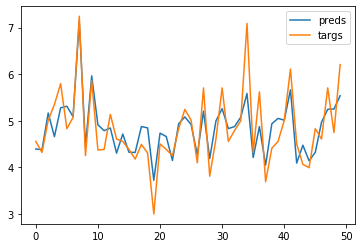

In [103]:
plt.plot(range(len(targs[450:500])), preds[450:500], label='preds')
plt.plot(range(len(targs[450:500])), targs[450:500], label='targs')
plt.legend()

In [104]:
def rmse(pred, targ):
    return np.sqrt(np.mean((pred-targ)**2))

In [105]:
rmse(preds, targs)

0.632222665689681

In [106]:
np.mean(df['price'])

159.1989177563074